# this project use bing image search API, FastAI library to do classification (lion vs horse)
## please use google colab if it doesn't work on local computer
## Images are downloaded using bing image api doesn't work sometimes (and can not be pushed to git) so I attach a link of that image folders to google drive https://drive.google.com/drive/folders/17oNJxMpkl-AyZaD3NBSpqq2X3P6Zy5GP?usp=sharing

In [10]:
#hide
!pip install fastai --upgrade --quiet
!pip install -Uqq fastbook #installing fastbook
import fastbook
fastbook.setup_book()

ERROR: Invalid requirement: '#installing'


In [11]:
import torch
print(torch.__version__)

1.7.1


In [12]:
#hide
from fastbook import *
from fastai.vision.widgets import *
# Numpy and pandas by default assume a narrow screen - this fixes that
from nbdev.showdoc import *
from ipywidgets import widgets
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
from pathlib import *


In [13]:
key = os.environ.get('AZURE_SEARCH_KEY', '2746812e0f4143008b236cd7a8cd34e7')

In [36]:
results = search_images_bing(key, 'horse')


In [37]:
ims = results.attrgot('contentUrl')
ims[0]

'http://thestyleinspiration.com/wp-content/uploads/2019/10/Arabian-Horses-.jpg'

In [59]:
bear_types = 'horse','lion'
path = Path('./horsevslion')
path

Path('horsevslion')

In [60]:
bear_types

('horse', 'lion')

In [62]:
if not path.exists():
    path.mkdir()
for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{o}')
    download_images(dest, urls=results.attrgot('contentUrl'))
    
doc(download_images)
dest

Path('horsevslion/lion')

In [63]:
fns = get_image_files(path)
fns

(#348) [Path('horsevslion/imageA.jpg'),Path('horsevslion/imageB.jpg'),Path('horsevslion/horse/00000000.jpg'),Path('horsevslion/horse/00000001.jpg'),Path('horsevslion/horse/00000002.jpg'),Path('horsevslion/horse/00000003.jpeg'),Path('horsevslion/horse/00000003.jpg'),Path('horsevslion/horse/00000004.jpeg'),Path('horsevslion/horse/00000004.jpg'),Path('horsevslion/horse/00000005.jpg')...]

In [64]:
failed = verify_images(fns)
failed

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [33]:
failed.map(Path.unlink);

In [45]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [46]:

dls = bears.dataloaders(path)


TypeError: 'NoneType' object is not iterable

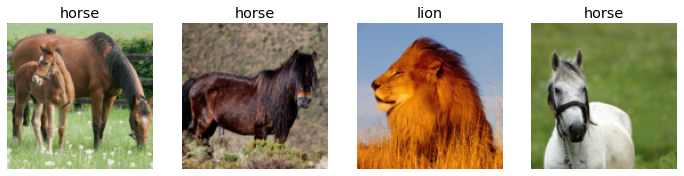

In [22]:
dls.valid.show_batch(max_n=4, nrows=1)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


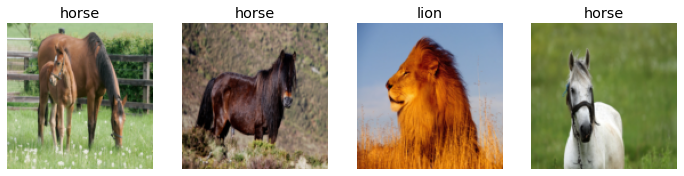

In [23]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


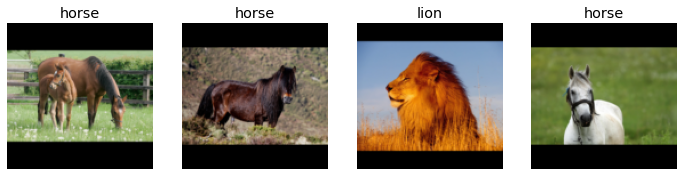

In [24]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


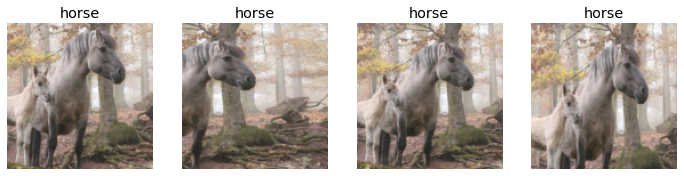

In [25]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


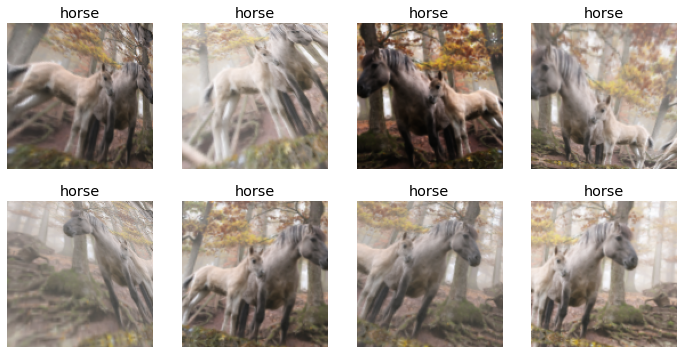

In [26]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [27]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [28]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(2)

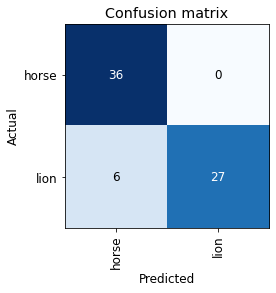

In [29]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

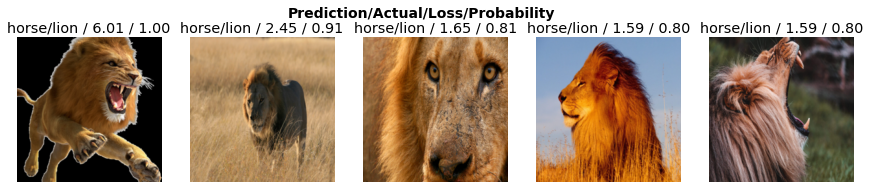

In [30]:
interp.plot_top_losses(5, nrows=1)

In [31]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [32]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [59]:
learn.export()
path=Path()
path.ls(file_exts='.pkl')
learn_inf = load_learner(path/'export.pkl')

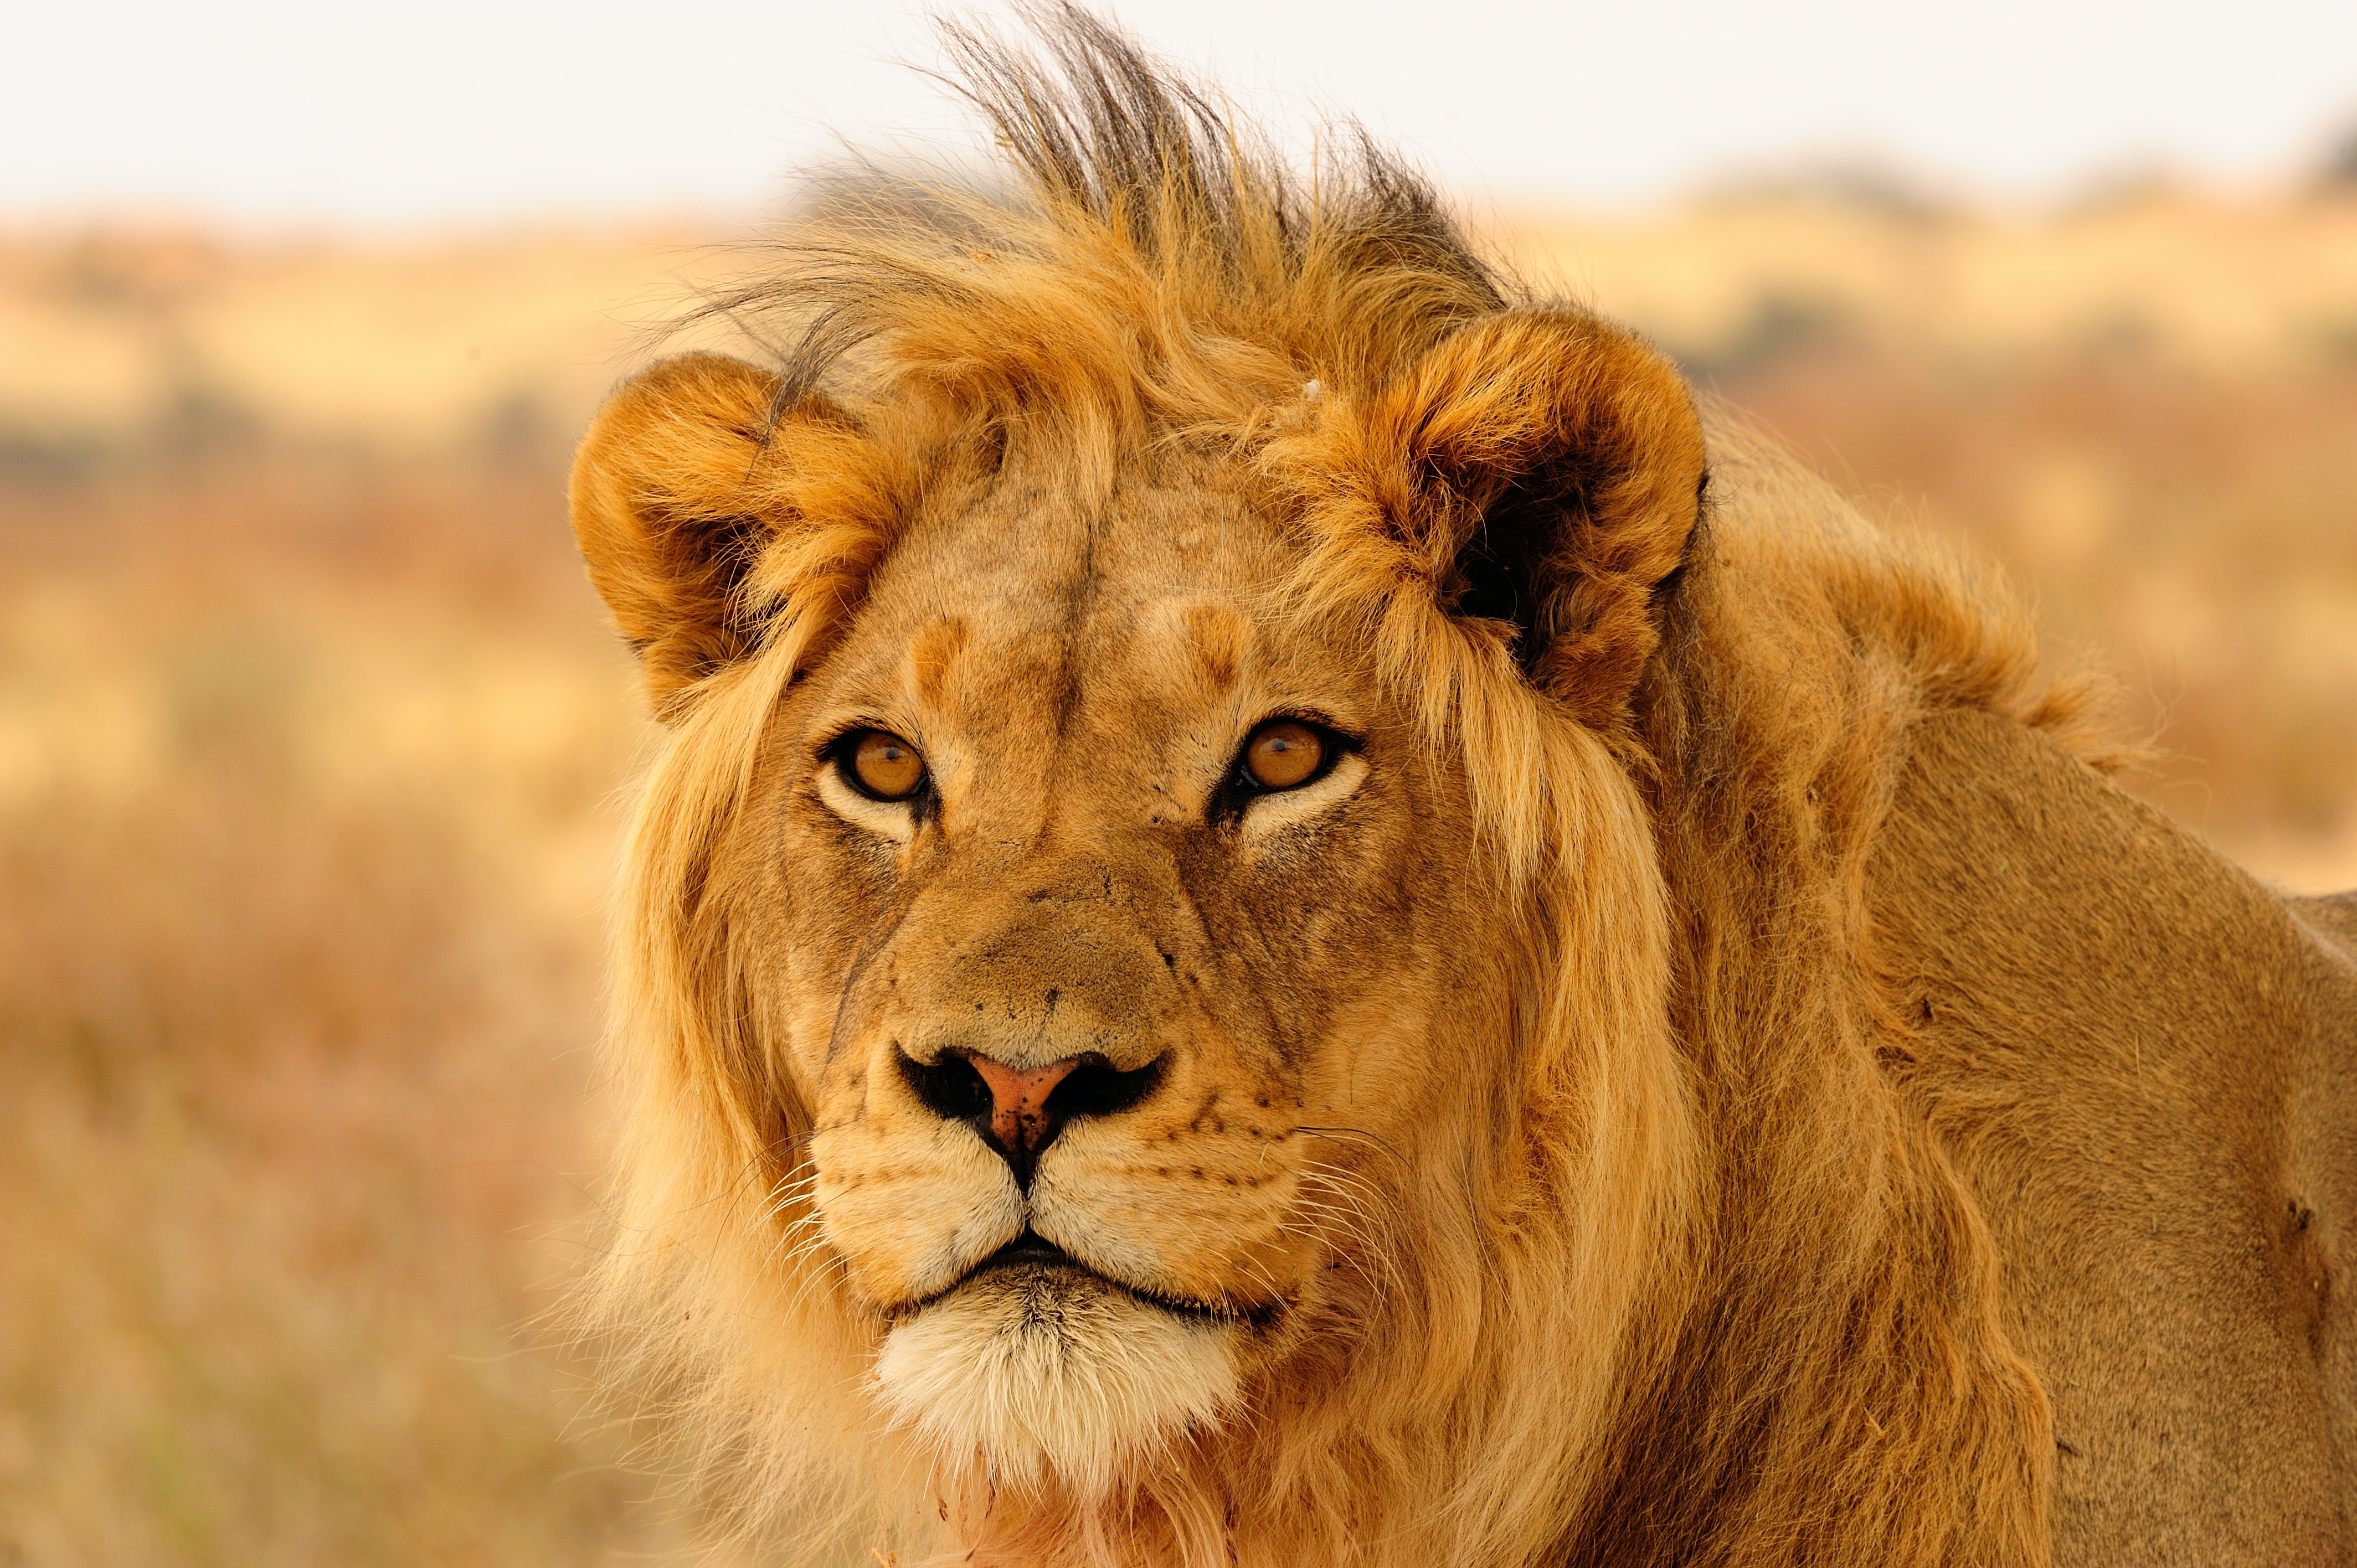

In [63]:
#there are 2 images outside of the horsevslion folder used for testing training model
from IPython.display import Image
Image(filename='horsevslion/imageA.jpg')  

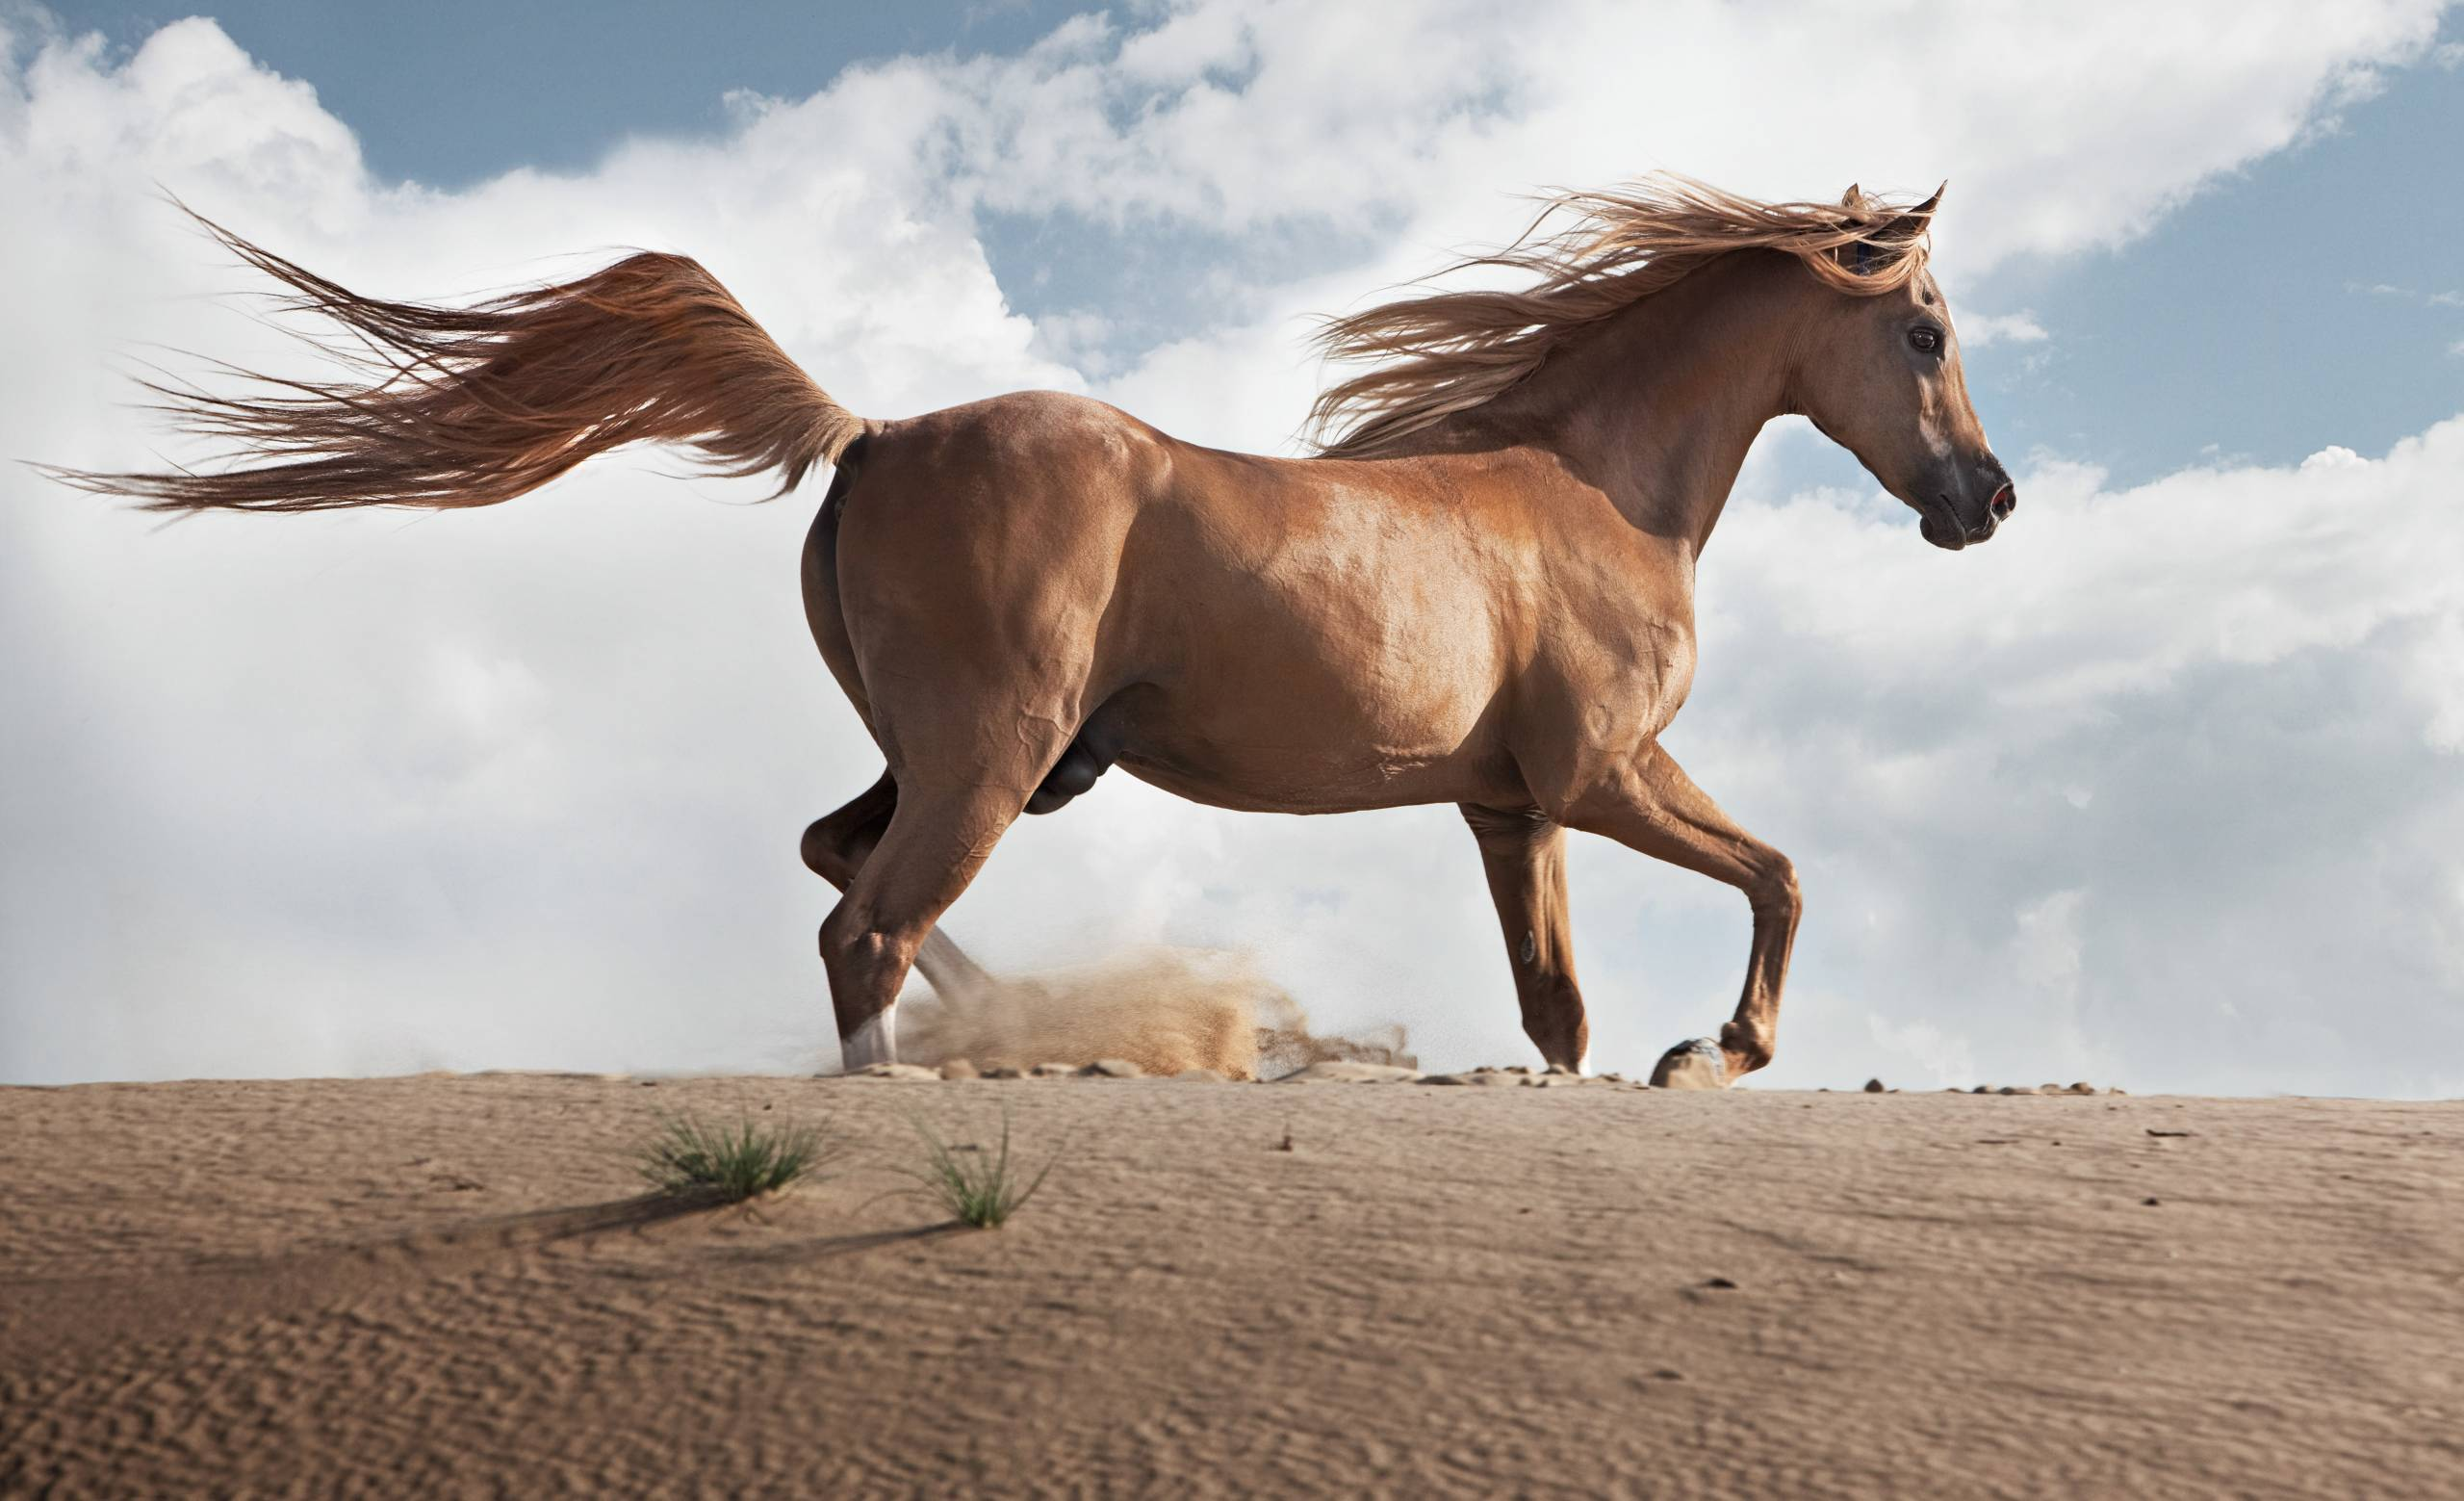

In [64]:
Image(filename='horsevslion/imageB.jpg')

In [50]:
lion_image_test_result,_,_=learn_inf.predict('horsevslion/imageA.jpg')
print("imageA.jpg is predictet to be a "+lion_image_test_result)
lion_image_test_result,_,_=learn_inf.predict('horsevslion/imageB.jpg')
print("imageB.jpg is predictet to be a "+lion_image_test_result)

imageA.jpg is predictet to be a lion


imageB.jpg is predictet to be a horse


In [65]:
learn_inf.dls.vocab

['horse', 'lion']

In [66]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [72]:
PILImage.create(btn_upload.data[0])
img = PILImage.create(btn_upload.data[-1])
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [75]:
pred,pred_idx,probs = learn_inf.predict(img)
print("the uploaded image is a",pred)

the uploaded image is a horse
